In [1]:
import os
import symbolica
symbolica.set_license_key(os.environ["SYMBOLICA_KEY_UNI"])
from symbolica import S, E, N
from IPython.display import display_latex, Latex
import matplotlib.pyplot as plt
import numpy as np
from integrand_builder import *
from symbolica_vectors import *

┌────────────────────────────────────────────────────────┐
│ You are running a restricted Symbolica instance.       │
│                                                        │
│ This mode is only permitted for non-commercial use and │
│ is limited to one instance and core per machine.       │
│                                                        │
│ Hobbyists can easily acquire a free license key        │
│ that unlocks all cores and removes this banner:        │
│                                                        │
│   from symbolica import *                              │
│   request_hobbyist_license('YOUR_NAME', 'YOUR_EMAIL')  │
│                                                        │
│ All other users can obtain a free 30-day trial key:    │
│                                                        │
│   from symbolica import *                              │
│   request_trial_license('NAME', 'EMAIL', 'EMPLOYER')   │
│                                                       

In [2]:
i = symbolica.Expression.I
q1, q2, p11, p12, p21, p22, m = S('q1','q2', 'p11', 'p12','p21','p22', 'm')
eps = S('e') #greek letters dont work as expected, therefore use e

def pcr(E, p):
    return 1/(E**2-p**2 - m**2 + i*eps)

integrand = -i * pcr(q1, q2)*pcr(q1+p11, q2+p12)*pcr(q1-p21, q2-p22)

display_latex(Latex(integrand.to_latex()))

In [3]:
integrand_eval = integrand.evaluator({
    m:      symbolica.Expression.num(0),
    eps:    symbolica.Expression.num(1)/1000,
    p11:    symbolica.Expression.num(1),
    p12:    symbolica.Expression.num(0),
    p21:    symbolica.Expression.num(1),
    p22:    symbolica.Expression.num(0),
},{},
    [q1, q2])

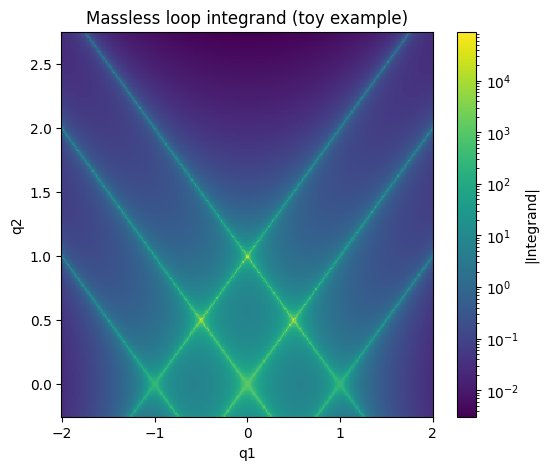

In [4]:
# Create a NumPy meshgrid for q1, q2
from matplotlib.colors import LogNorm


q1_vals = np.linspace(-2, 2, 300)
q2_vals = np.linspace(-0.25, 2.75, 300)
Q1, Q2 = np.meshgrid(q1_vals, q2_vals)

# Evaluate the integrand on the grid
Z = np.zeros_like(Q1, dtype=np.complex128)
for i in range(Q1.shape[0]):
    for j in range(Q1.shape[1]):
        Z[i,j] = integrand_eval.evaluate_complex([[Q1[i,j], Q2[i,j]]])[0][0]

# Plot the absolute value of the integrand
plt.figure(figsize=(6,5))
plt.pcolormesh(Q1, Q2, np.abs(Z), shading='auto', cmap='viridis', norm=LogNorm())
plt.colorbar(label='|Integrand|')
plt.xlabel('q1')
plt.ylabel('q2')
plt.title('Massless loop integrand (toy example)')
plt.show()

In [5]:
def plot_threshold_subtraction(p1, p2, mass):
    b = IntegrandBuilder()
    eta = IntegrandEtaBuilder(b, 0,1)

    params_symbols = [symbolica.Expression.PI,b.p1,b.p2,b.m,b.integrand]
    params_values = [np.pi,p1,p2,mass]
    
    (ct1, k1), (ct2, k2) = eta.counter_term(b.integrand)
    term = N(1)/eta.eta(b.integrand)
    ct = ct1 + ct2
    
    term = b.improved_ltd_expression()
    ct = b.counter_term(p1, p2, mass)

    
    eta_eval = WrappedEvaluator(term, params_symbols ,params_values)
    ct_eval = WrappedEvaluator(ct, params_symbols, params_values)
    sub_eval = WrappedEvaluator(term-ct, params_symbols, params_values)
    lims = (-5,5,-5,5)


    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plot_slice(eta_eval, lims = lims)
    
    #k1_x_eval = WrappedEvaluator(k2.symbols[0], params_symbols, params_values)
    #k1_y_eval = WrappedEvaluator(k2.symbols[1], params_symbols, params_values)
    #samples = np.random.random([20,2]) * 2 - 1
    #poles_x = np.array([k1_x_eval(np.array([x,y,0])) for (x,y) in samples])
    #poles_y = np.array([k1_y_eval(np.array([x,y,0])) for (x,y) in samples])
    #plt.scatter(poles_x, poles_y)
    
    plt.subplot(1,3,2)
    plot_slice(ct_eval, lims = lims)
    plt.subplot(1,3,3)
    plot_slice(sub_eval, lims = lims)
    plt.show()


    x0 = np.zeros(3)
    x_hat = np.array([1,0,0])
    lims = (-5,5)

    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    plot_line(eta_eval,x0, x_hat, lims)
    plt.subplot(1,3,2)
    plot_line(ct_eval,x0, x_hat, lims)
    plt.subplot(1,3,3)
    plot_line(sub_eval,x0, x_hat, lims)
    


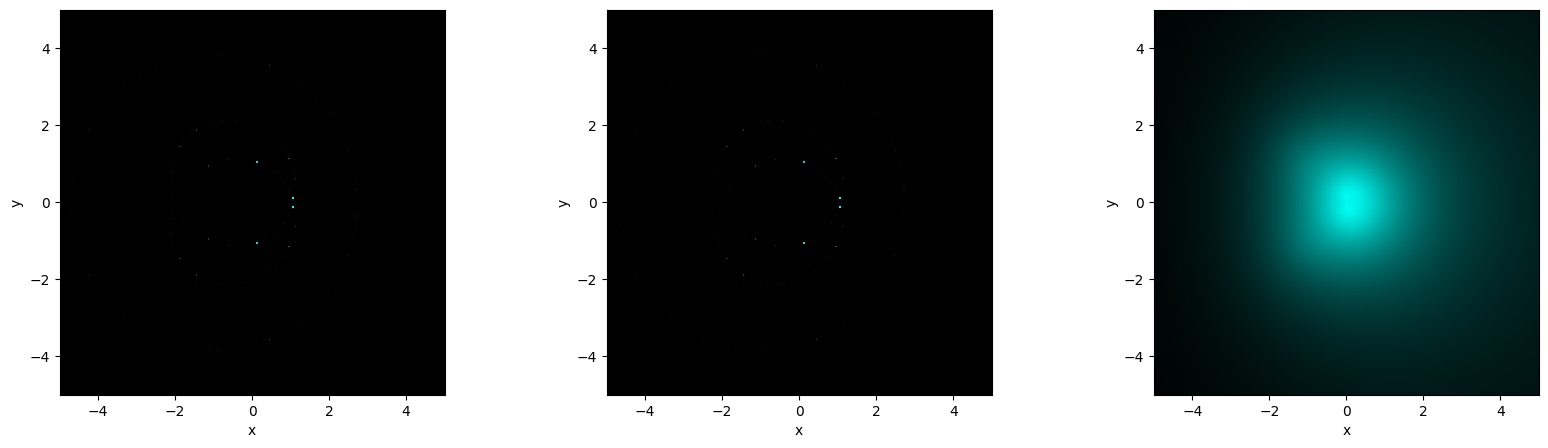

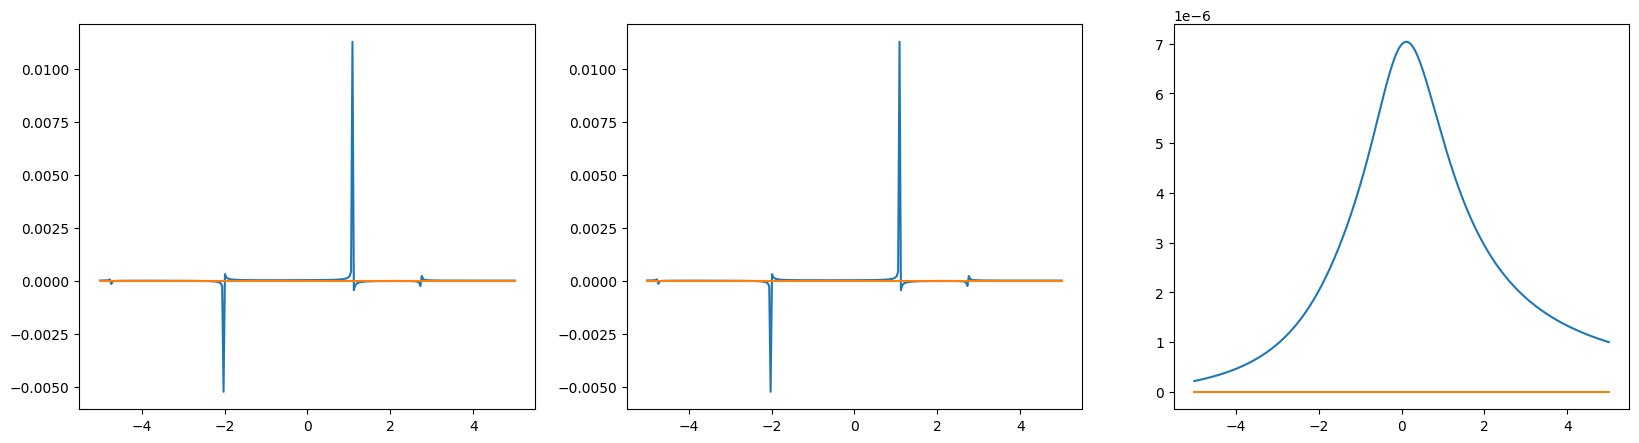

In [6]:
p1 = np.array([-4,1,-1, 0])
p2 = np.array([-4,-1,-1,  0])
mass = 1
plot_threshold_subtraction(p1,p2,mass)

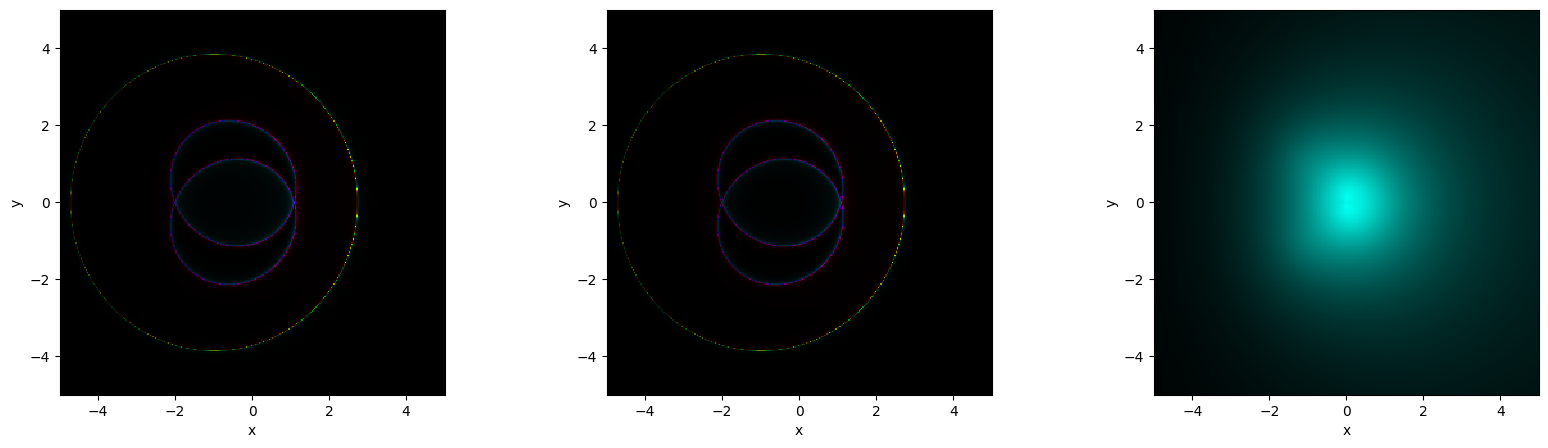

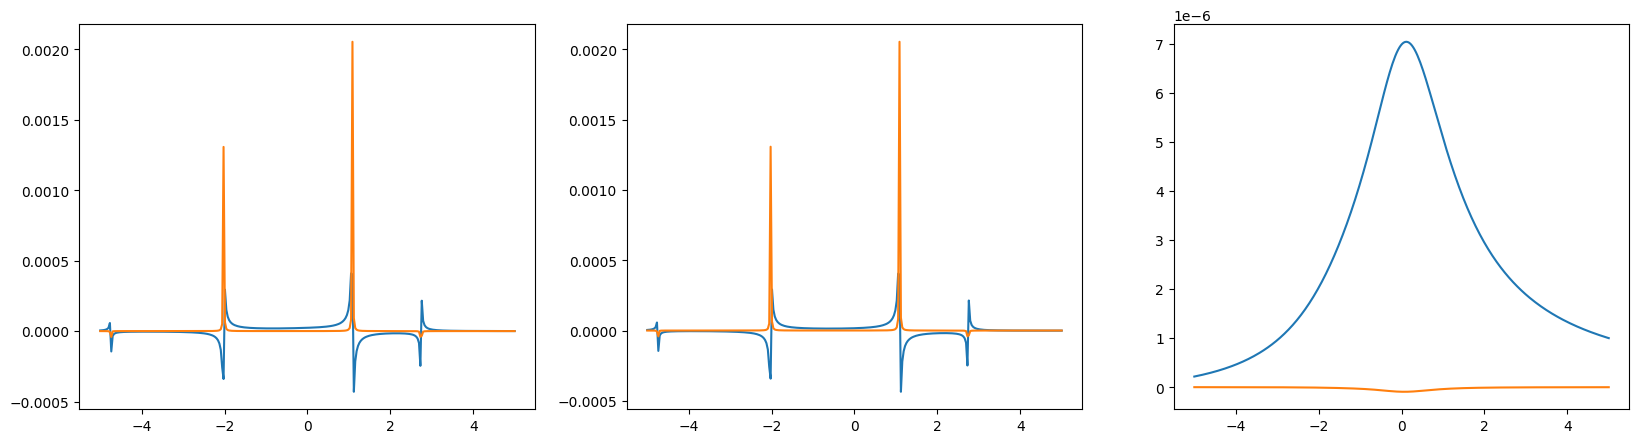

In [7]:
p1 = np.array([-4,1,-1, 0])
p2 = np.array([-4,-1,-1,  0])
mass = 1+0.01j
plot_threshold_subtraction(p1,p2,mass)

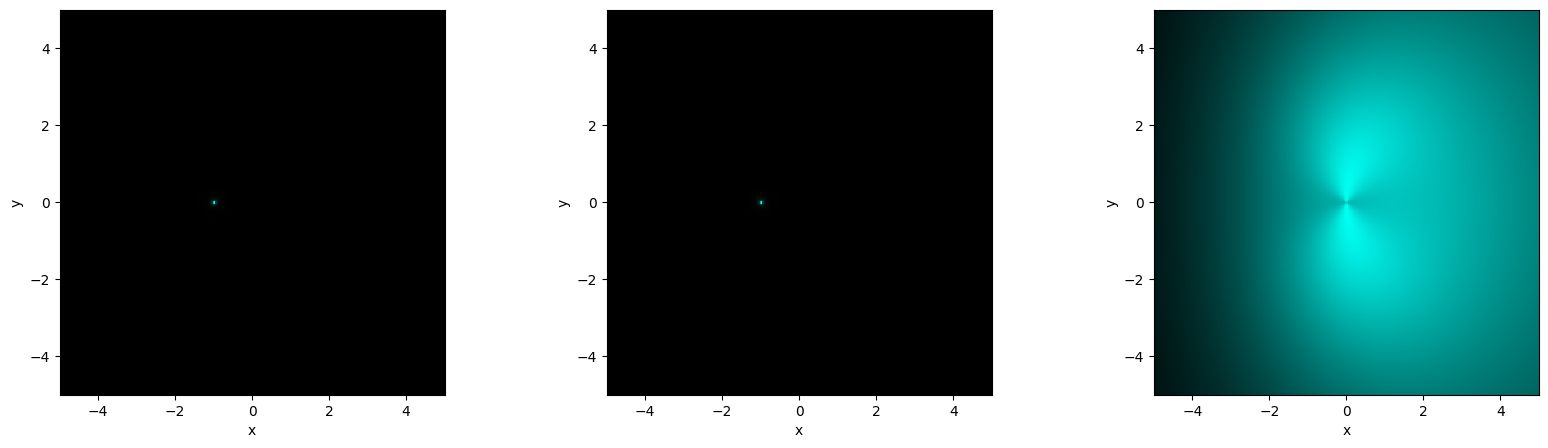

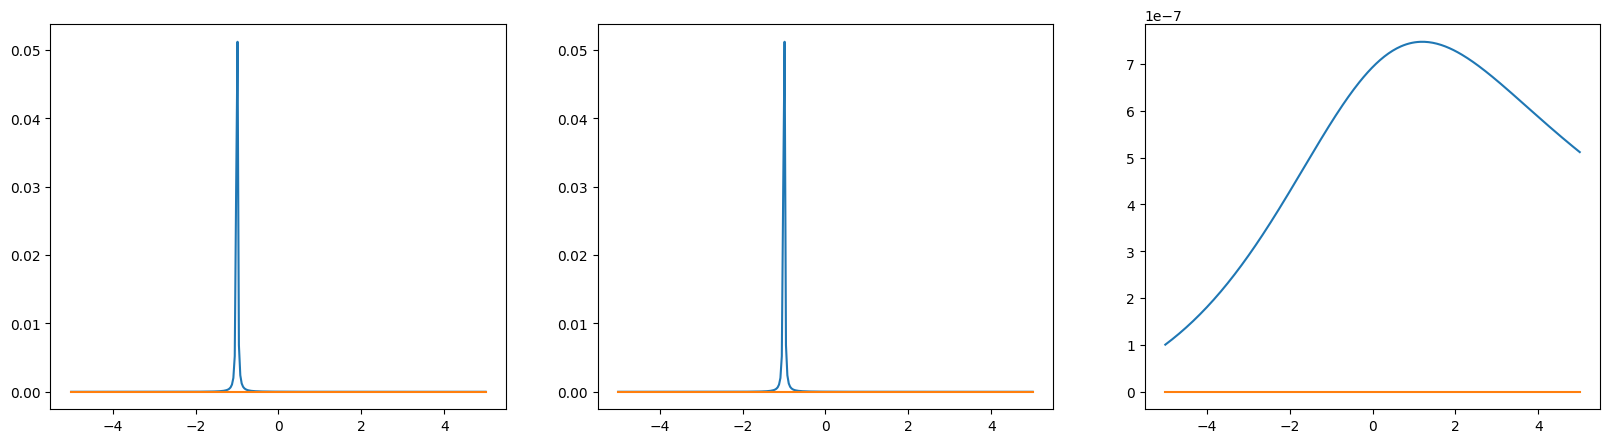

In [20]:
p1 = np.array([-4,1,-1, 0])
p2 = np.array([-4,-1,-1,  0])
mass = 3.873
plot_threshold_subtraction(p1,p2,mass)